In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

In [3]:
df = pd.read_csv("C:/Users/Aravi/PycharmProjects/Liar2-Misinformation-Network-Analysis/data/LIAR/cleaned_train")

In [4]:
def map_party(party):
    party = party.lower()
    if party in ["democrat", "democratic-farmer-labor"]:
        return "Democrat"
    elif party in ["republican", "tea-party-member", "ocean-state-tea-party-action"]:
        return "Republican"
    elif party in ["independent", "libertarian", "moderate"]:
        return "Independent"
    else:
        return "Other"

df['party_grouped'] = df['party'].apply(map_party)

In [35]:
import matplotlib.patches as mpatches
legend_labels = [
    mpatches.Patch(color="#1f77b4", label="Democrat"),
    mpatches.Patch(color="#d62728", label="Republican"),
    mpatches.Patch(color="#2ca02c", label="Independent"),
    mpatches.Patch(color="#9467bd", label="Other"),
    mpatches.Patch(color="#d62728", label="False / Pants-Fire"),
    mpatches.Patch(color="#1f77b4", label="True / Mostly True"),
    mpatches.Patch(color="#ff7f0e", label="Half True"),
    mpatches.Patch(color="#2ca02c", label="Barely True"),
    mpatches.Patch(color="#aaaaaa", label="Statement")
]


In [45]:
# === Graph 1: Speaker Co-Occurrence Graph (by context) ===
import os
os.makedirs("graphs", exist_ok=True)

nx.write_gml(G1, "graphs/G1_speaker_cooccurrence.gml")
G1 = nx.Graph()
for context, group in df.groupby('context_category'):
    speakers = group['speaker'].dropna().unique()
    for s1, s2 in combinations(speakers, 2):
        if G1.has_edge(s1, s2):
            G1[s1][s2]['weight'] += 1
        else:
            G1.add_edge(s1, s2, weight=1)

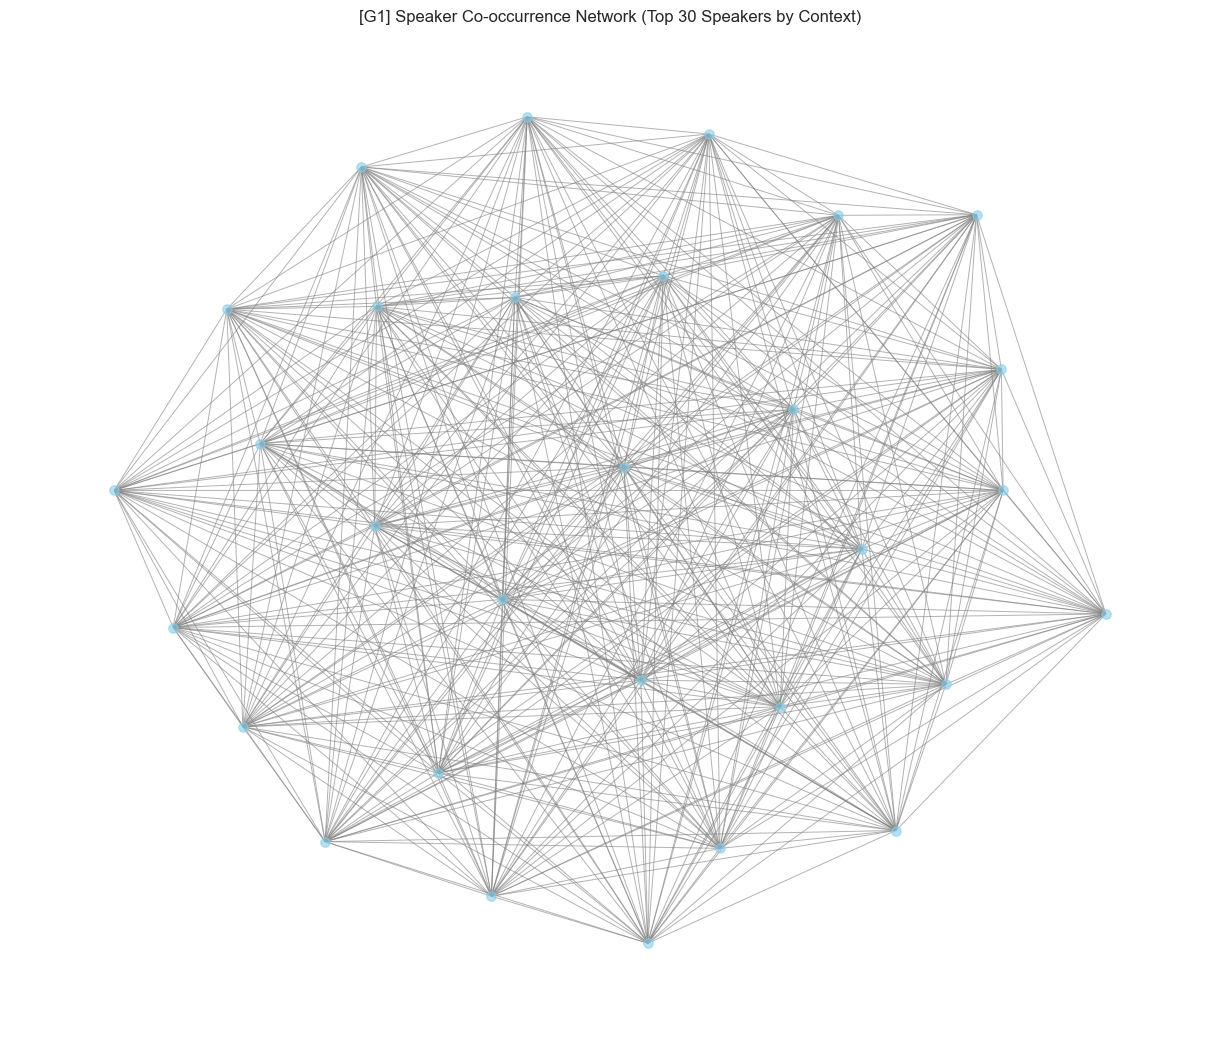

In [33]:
# Visualization
G1_top = sorted(G1_filtered.degree, key=lambda x: x[1], reverse=True)[:30]
G1_sub = G1_filtered.subgraph([n for n, _ in G1_top])
pos = nx.spring_layout(G1_sub, k=0.4, seed=42)
plt.figure(figsize=(12, 10))
nx.draw(G1_sub, pos, node_size=45, node_color='skyblue', edge_color='gray', width=0.7, alpha=0.6, with_labels=False)
plt.title("[G1] Speaker Co-occurrence Network (Top 30 Speakers by Context)")
plt.axis('off')
#plt.tight_layout()
plt.show()

In [52]:
G2_alt = nx.Graph()
for subject, group in df.groupby('subject'):
    speakers = group['speaker'].dropna().unique()
    for s1, s2 in combinations(speakers, 2):
        if G2_alt.has_edge(s1, s2):
            G2_alt[s1][s2]['weight'] += 1
        else:
            G2_alt.add_edge(s1, s2, weight=1)
nx.write_gml(G2, "graphs/G2_speaker_cooccurrence.gml")

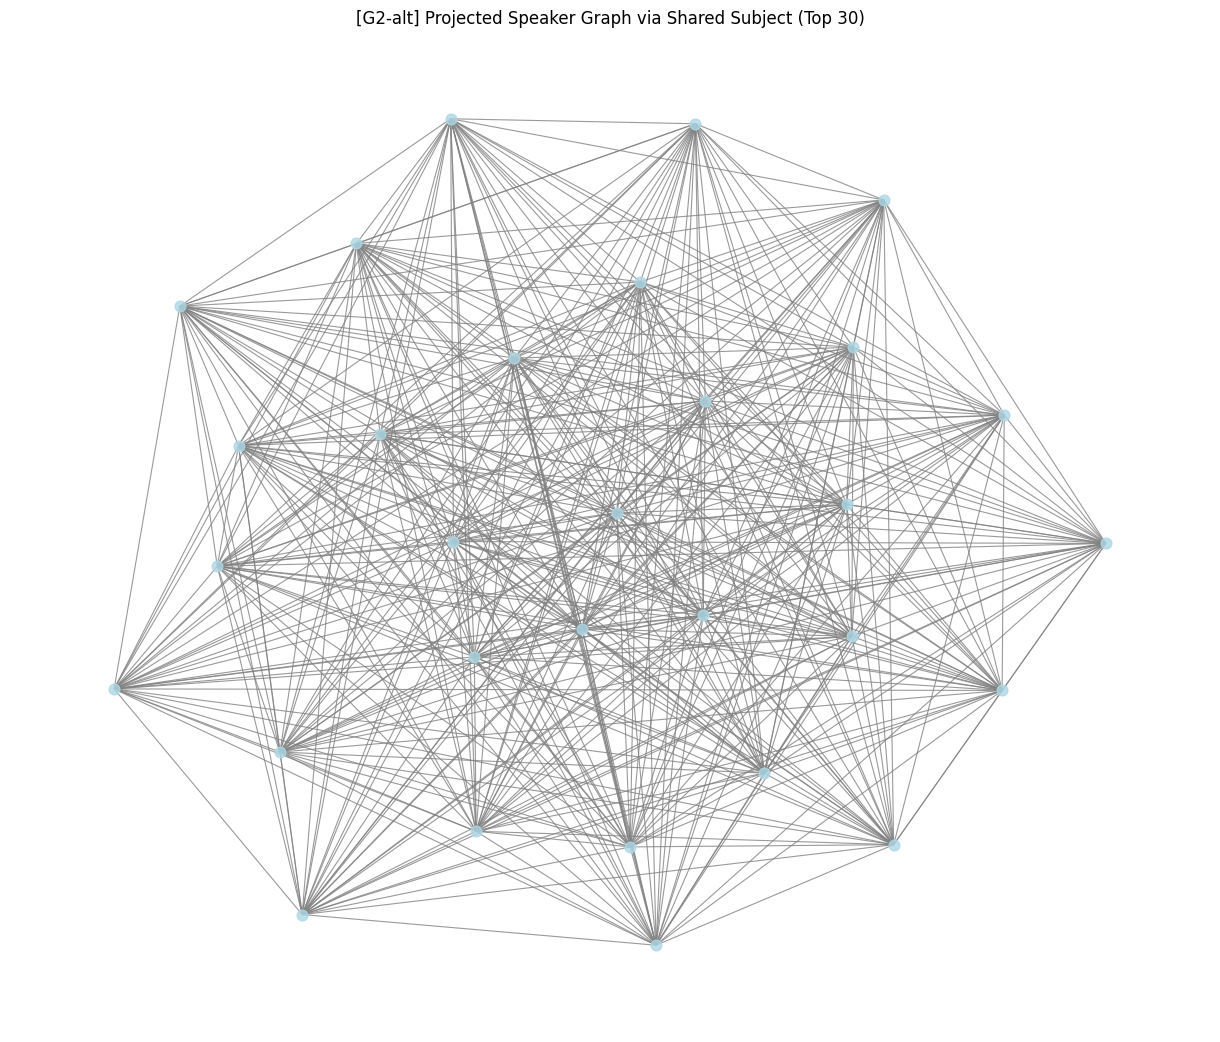

In [49]:
# Visualize top speakers
G2_alt_top = sorted(G2_alt.degree, key=lambda x: x[1], reverse=True)[:30]
G2_alt_sub = G2_alt.subgraph([n for n, _ in G2_alt_top])
pos = nx.spring_layout(G2_alt_sub, k=0.4, seed=0)
plt.figure(figsize=(12, 10))
nx.draw(G2_alt_sub, pos, node_size=60, node_color='lightblue', edge_color='gray', width=0.8, alpha=0.8, with_labels=False)
plt.title("[G2-alt] Projected Speaker Graph via Shared Subject (Top 30)")
plt.axis('off')
plt.show()

In [50]:
# === Graph 3: Speaker–Party Graph (simplified affiliations) ===
G3 = nx.Graph()
for _, row in df.iterrows():
    G3.add_edge(row['speaker'], row['party_grouped'])
nx.write_gml(G3, "graphs/G3_speaker_party_affiliation.gml")

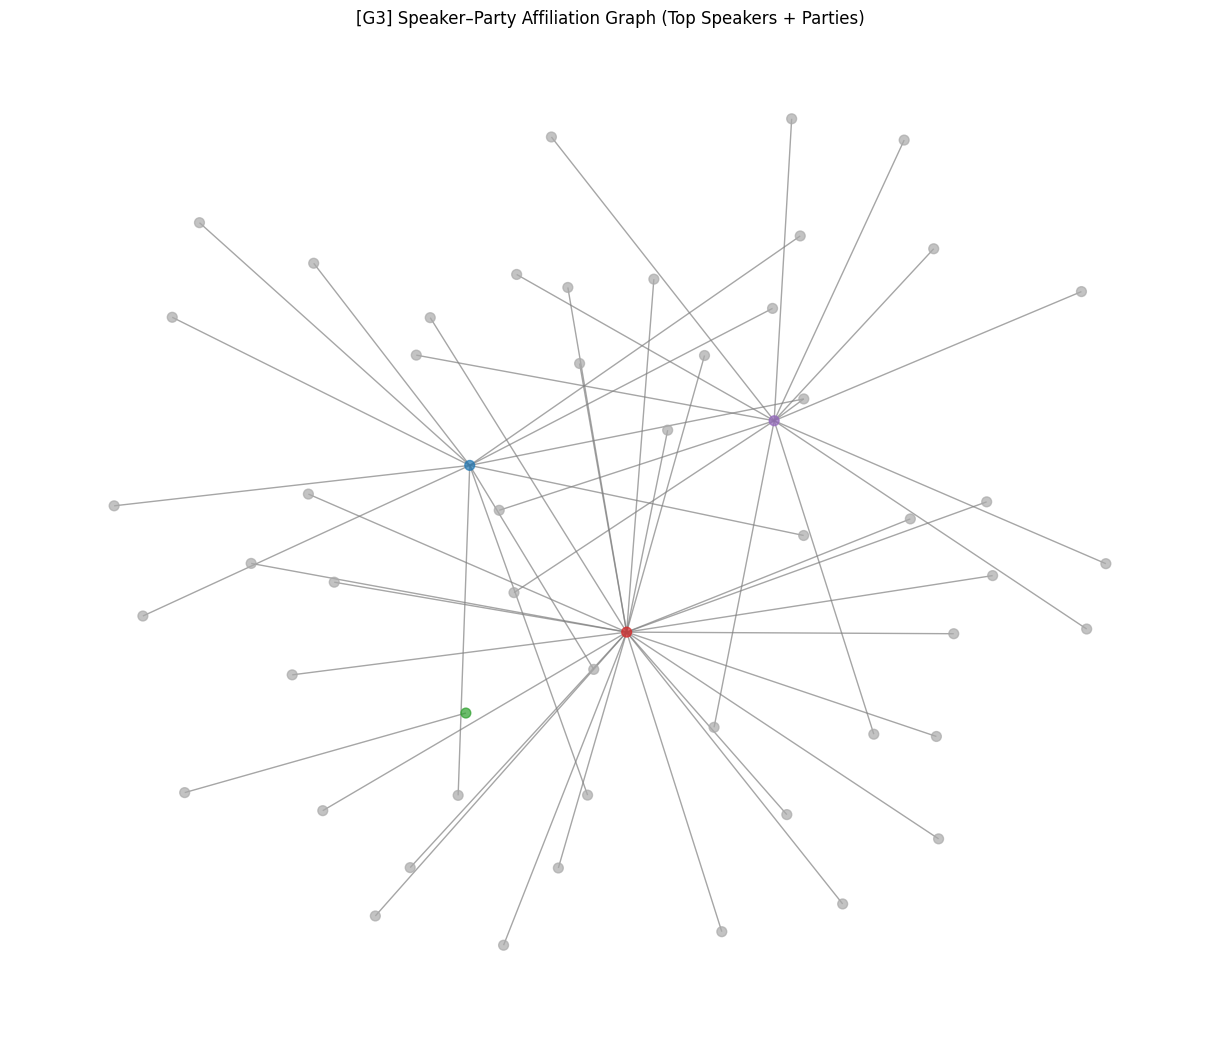

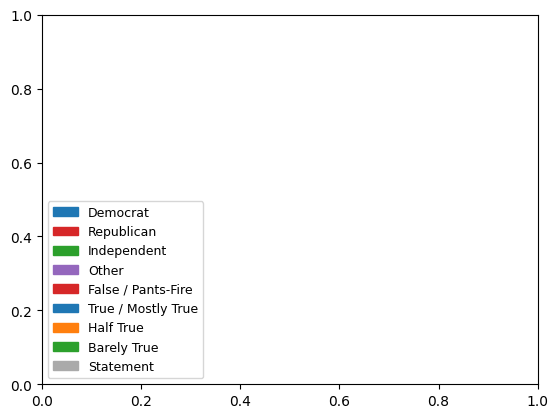

In [36]:
speaker_degree = dict(G3.degree())
top_speakers = sorted([n for n in speaker_degree if n not in ['Democrat', 'Republican', 'Independent', 'Other']], key=lambda x: speaker_degree[x], reverse=True)[:50]
G3_sub = G3.subgraph(top_speakers + ['Democrat', 'Republican', 'Independent', 'Other'])
pos = nx.spring_layout(G3_sub, k=0.7, seed=1)
plt.figure(figsize=(12, 10))
node_colors = ['#1f77b4' if n == 'Democrat' else '#d62728' if n == 'Republican' else '#2ca02c' if n == 'Independent' else '#9467bd' if n == 'Other' else '#aaaaaa' for n in G3_sub.nodes]
nx.draw(G3_sub, pos, node_size=50, node_color=node_colors, edge_color='gray', alpha=0.7, with_labels=False)
plt.title("[G3] Speaker–Party Affiliation Graph (Top Speakers + Parties)")
plt.axis('off')
#plt.tight_layout()
plt.show()

plt.legend(handles=legend_labels, loc='lower left', fontsize=9, frameon=True)
plt.show()

In [51]:
# === Graph 4: Statement–Label Graph (Credibility Connectivity) ===
G4 = nx.Graph()
for _, row in df.iterrows():
    G4.add_edge(row['id'], row['label'])
nx.write_gml(G4, "graphs/G4_statement_label_graph.gml")

In [41]:
# Keep only the top 100 most frequent statements for visibility
statement_counts = df['id'].value_counts().nlargest(100).index
labels_in_use = df[df['id'].isin(statement_counts)]['label'].unique()
G4_filtered = G4.subgraph(list(statement_counts) + list(labels_in_use))

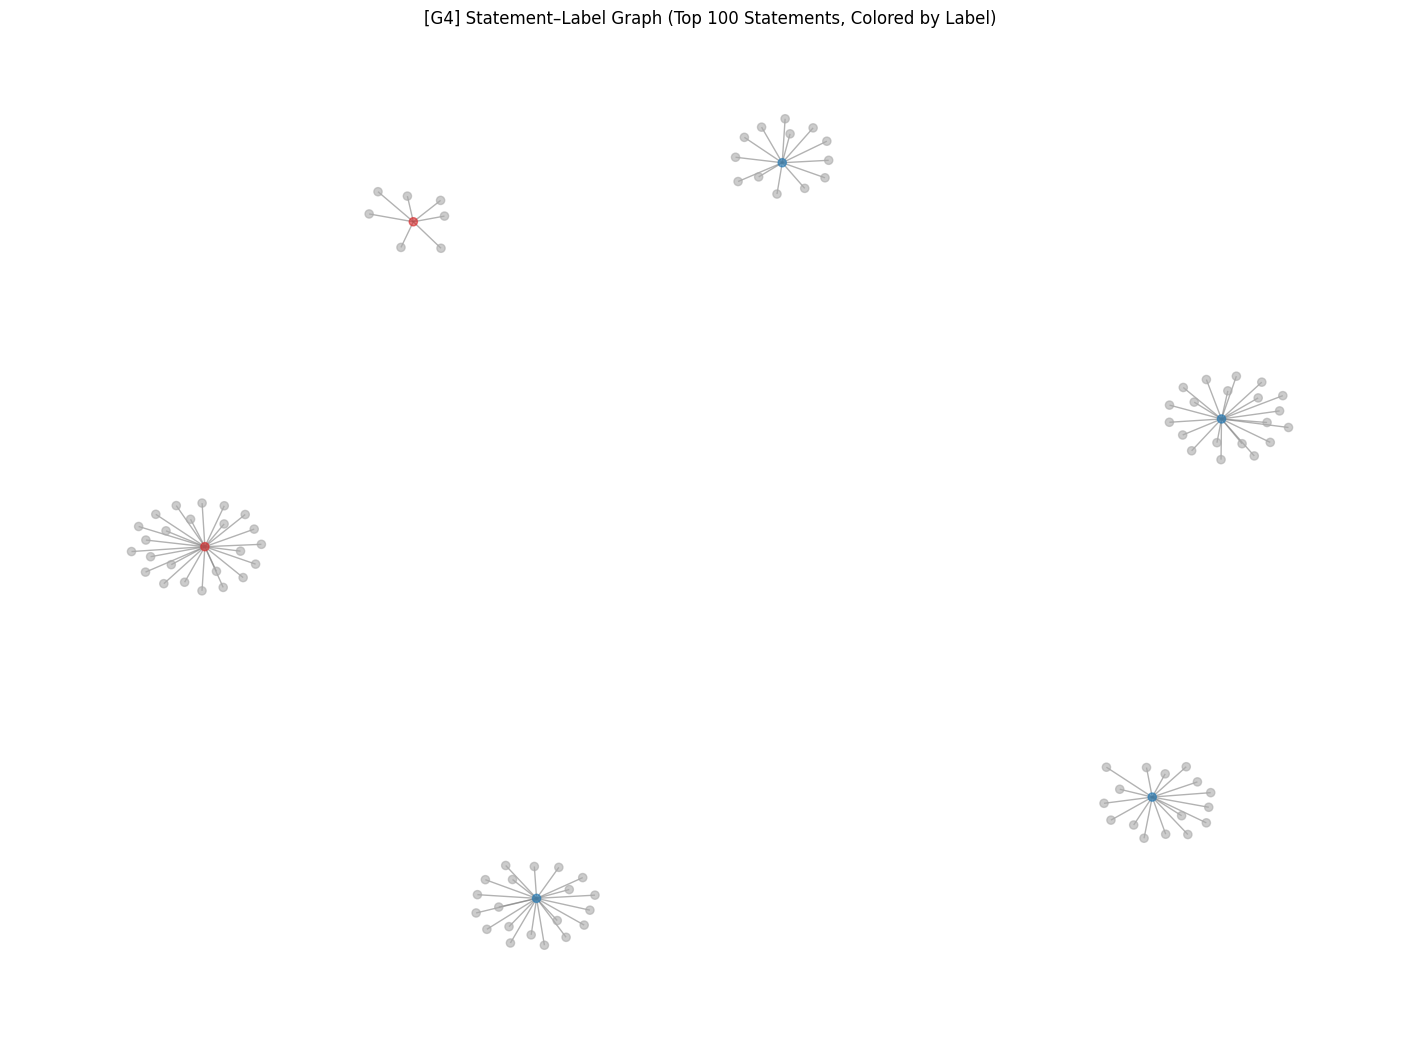

In [44]:
# Visualize graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G4_filtered, seed=3)
node_colors = [
    "#d62728" if n in labels_in_use and ('false' in str(n).lower() or 'pants' in str(n).lower())
    else "#1f77b4" if n in labels_in_use and ('true' in str(n).lower() or 'mostly' in str(n).lower())
    else "#ff7f0e" if n in labels_in_use and ('half' in str(n).lower())
    else "#2ca02c" if n in labels_in_use and ('barely' in str(n).lower())
    else "#aaaaaa"
    for n in G4_filtered.nodes
]
nx.draw(G4_filtered, pos, node_size=35, node_color=node_colors, edge_color='gray', alpha=0.6, with_labels=False)
plt.title("[G4] Statement–Label Graph (Top 100 Statements, Colored by Label)")
plt.axis('off')
#plt.tight_layout()
plt.show()

In [53]:
G5 = nx.Graph()
sample_df = df.sample(n=5000, random_state=42)
for _, row in sample_df.iterrows():
    speaker, statement, label = row["speaker"], row["statement"], row["label"]
    G5.add_node(speaker, type="speaker")
    G5.add_node(statement, type="statement", label=label)
    G5.add_edge(speaker, statement, label=label)

nx.write_gml(G5, "graphs/G5_speaker_statement_bipartite.gml")

In [55]:
# Degree Centrality Analysis
degree_centrality = nx.degree_centrality(G5)
misinfo_speakers = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
misinfo_speakers_df = pd.DataFrame(misinfo_speakers, columns=["Speaker", "Degree Centrality"])
print("[G5] Top 10 Misinformation Spreaders (by Degree Centrality):")
print(misinfo_speakers_df)

[G5] Top 10 Misinformation Spreaders (by Degree Centrality):
           Speaker  Degree Centrality
0     barack-obama           0.036169
1     donald-trump           0.019476
2  hillary-clinton           0.016547
3      mitt-romney           0.013326
4     scott-walker           0.011715
5      john-mccain           0.009811
6      marco-rubio           0.008932
7       rick-perry           0.008786
8      chain-email           0.008640
9       rick-scott           0.008200


In [42]:
G6 = nx.Graph()
for _, row in df.iterrows():
    speaker = row["speaker"]
    party = row["party"]
    statement = row["statement"]
    label = row["label"]

    if pd.notna(speaker):
        G6.add_node(speaker, type="person")
    if pd.notna(party):
        G6.add_node(party, type="political_party")
    if pd.notna(statement):
        G6.add_node(statement, type="statement", truth_label=label)
    if pd.notna(speaker) and pd.notna(party):
        G6.add_edge(speaker, party)
    if pd.notna(speaker) and pd.notna(statement):
        G6.add_edge(speaker, statement, label=label)

In [43]:
nx.write_gml(G6, "graphs/G6_speaker_party_statement.gml")

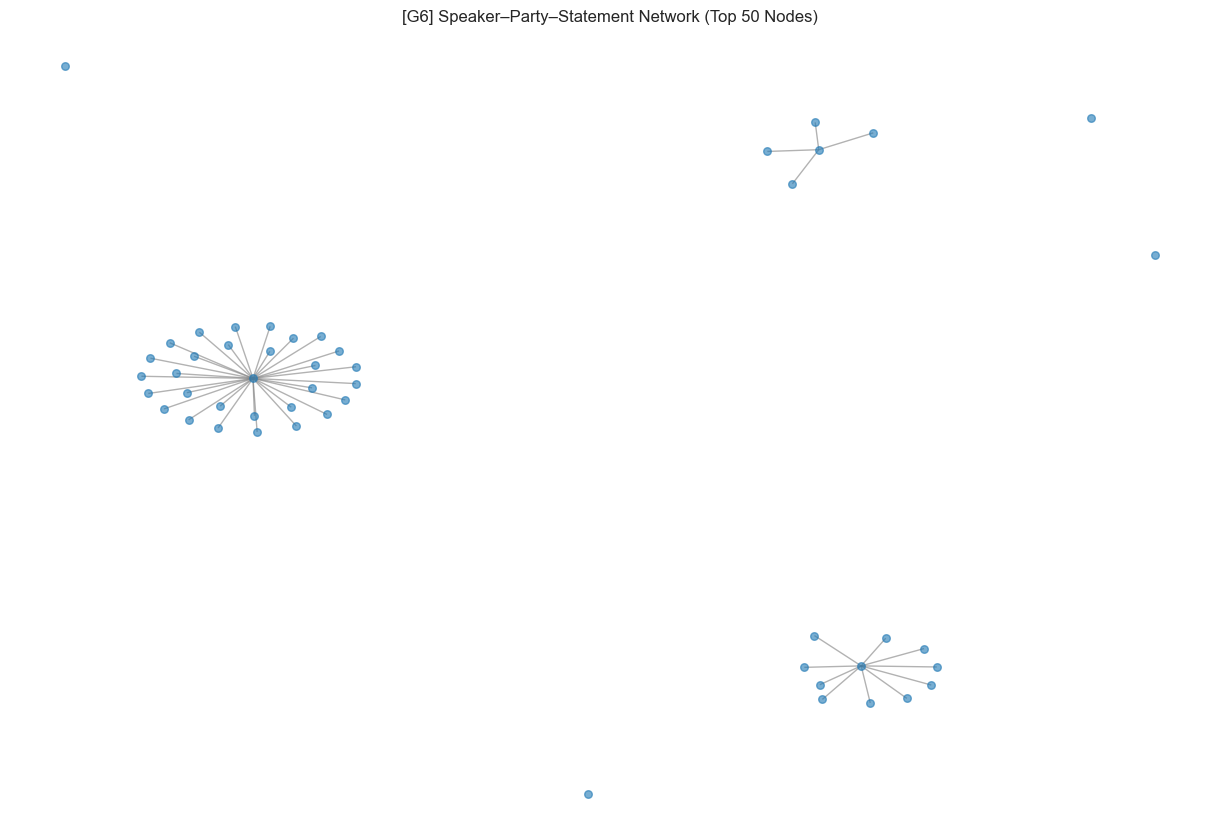

In [50]:
# Filter to top 100 nodes by degree for clearer layout
G6_top_nodes = sorted(G6.degree, key=lambda x: x[1], reverse=True)[:50]
G6_sub = G6.subgraph([n for n, _ in G6_top_nodes])

node_colors = []
for n in G6_sub.nodes(data=True):
    if n[1].get("type") == "political_party":
        node_colors.append("#d62728")  # red
    elif n[1].get("type") == "person":
        node_colors.append("#1f77b4")  # blue
    elif n[1].get("type") == "statement":
        node_colors.append("#ff7f0e")  # orange
    else:
        node_colors.append("#aaaaaa")  # fallback

# Layout and render
pos = nx.spring_layout(G6_sub, seed=1)
plt.figure(figsize=(12, 8))
nx.draw(G6_sub, pos, node_size=30, edge_color="gray", alpha=0.6, with_labels=False)
plt.title("[G6] Speaker–Party–Statement Network (Top 50 Nodes)")
plt.axis("off")
plt.savefig("graphs/G6_speaker_party_statement.png", dpi=300)
plt.show()

# Add legend
legend_items = [
    mpatches.Patch(color="#1f77b4", label="Speaker"),
    mpatches.Patch(color="#d62728", label="Party"),
    mpatches.Patch(color="#ff7f0e", label="Statement")
]